# Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

# Load the dataset

In [4]:
# Load dataset (local)
#dataset_zip = np.load('../dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='bytes')

# Load dataset (Kaggle)
dataset_zip = np.load('/kaggle/input/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='bytes')

In [5]:
# create a class dSpritesDataset for the DataLoader
class dSpritesDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        return img

# Specific to dSpritesDataset (0 or 1 values instead of 0 and 0.0039) 
class RescaleBinaryImage:
    def __call__(self, tensor):
        return tensor / tensor.max()

transform = transforms.Compose([
    transforms.ToTensor(),
    RescaleBinaryImage()
])

imgs = dataset_zip['imgs']
latent_values = dataset_zip['latents_values']
latent_classes = dataset_zip['latents_classes']
dsprites = dSpritesDataset(imgs, transform=transform)

# Take a subset of the dataset
subset_size = 15000
dsprites_small = random_split(dsprites, [subset_size, len(imgs)-subset_size])[0]
imgs_train, imgs_test = random_split(dsprites_small, [0.8, 0.2])

# Transform in DataLoader
batch_size = 64
imgs_trainloader = DataLoader(imgs_train, batch_size=batch_size, shuffle=False)
imgs_testloader = DataLoader(imgs_test, batch_size=batch_size, shuffle=False)

# Some visualizations

In [6]:
# Check shape of a batch of images
img = next(iter(imgs_trainloader))
img.shape

torch.Size([64, 1, 64, 64])

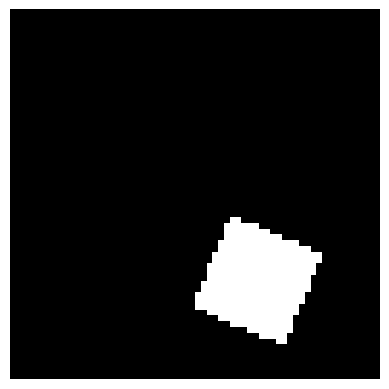

In [7]:
# view an image from dataloader
plt.imshow(img[0].permute(1,2,0), cmap='gray', vmin=img[0].min().item(), vmax=img[0].max().item())
plt.axis('off')
plt.show()

# The Beta-VAE architecture (same as the one in table 1, appendix A, in the FactorVAE paper)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim=64, z_dim=10, h_dim1=32, h_dim2=64, fc_dim=128, n_channels=1, kernel_size=4, stride=2):
        super(Encoder, self).__init__()

        self.input_dim = input_dim
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.h_dim1 = h_dim1
        self.h_dim2 = h_dim2
        self.z_dim = z_dim
        self.fc_dim = fc_dim
        
        self.output_size = 2

        self.conv1 = nn.Conv2d(self.n_channels, self.h_dim1, kernel_size=self.kernel_size, stride=self.stride)
        self.conv2 = nn.Conv2d(self.h_dim1, self.h_dim1, kernel_size=self.kernel_size, stride=self.stride)
        self.conv3 = nn.Conv2d(self.h_dim1, self.h_dim2, kernel_size=self.kernel_size, stride=self.stride)
        self.conv4 = nn.Conv2d(self.h_dim2, self.h_dim2, kernel_size=self.kernel_size, stride=self.stride)
        
        self.fc = nn.Linear(self.output_size * self.output_size * self.h_dim2, self.fc_dim)
        self.fc_mu = nn.Linear(self.fc_dim, self.z_dim)
        self.fc_logvar = nn.Linear(self.fc_dim, self.z_dim)

    def forward(self, x):
        """
        Encodes the input image (64x64 size for the dSpritesDataset)
            x : input image
        Returns :
            mu, logvar : latent parameters
        """
        out = F.relu(self.conv1(x))  # [64, 32, 31, 31]
        out = F.relu(self.conv2(out)) # [64, 32, 14, 14]
        out = F.relu(self.conv3(out)) # [64, 64, 6, 6]
        out = F.relu(self.conv4(out)) # [64, 64, 2, 2]
        
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, input_dim=64, z_dim=10, h_dim=32, h_dim2=64, fc_dim=128, n_channels=1, kernel_size=4, stride=2):
        super(Decoder, self).__init__()

        self.input_dim = input_dim
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.h_dim = h_dim
        self.h_dim2 = h_dim2
        self.z_dim = z_dim
        self.fc_dim = fc_dim

        self.fc1 = nn.Linear(self.z_dim, self.fc_dim)   # [64, 128]
        self.fc2 = nn.Linear(self.fc_dim, self.kernel_size * self.kernel_size * self.h_dim2)   # [64, 4 x 4 x 64] -> [64, 64, 4, 4]
        
        self.conv1 = nn.ConvTranspose2d(self.h_dim2, self.h_dim2, kernel_size=kernel_size, stride=stride, padding=1)    # [64, 64, 8, 8]
        self.conv2 = nn.ConvTranspose2d(self.h_dim2, self.h_dim, kernel_size=kernel_size, stride=stride, padding=1)     # [64, 32, 16, 16]
        self.conv3 = nn.ConvTranspose2d(self.h_dim, self.h_dim, kernel_size=kernel_size, stride=stride, padding=1)      # [64, 32, 32, 32]
        self.conv4 = nn.ConvTranspose2d(self.h_dim, self.n_channels, kernel_size=kernel_size, stride=stride, padding=1) # [64, 1, 64, 64]

    def forward(self, z):
        """
        Decodes from the sample z
            z : sample (z = mu + std * eps, eps from standard gaussian)
        Returns:
            y : reconstructed image, same shape as the input
        """
        out = F.relu(self.fc1(z))
        out = F.relu(self.fc2(out))
        out = out.reshape(out.shape[0], self.h_dim2, self.kernel_size, self.kernel_size)
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        y = torch.sigmoid(self.conv4(out))  # to ensure the image has values between 0 and 1
        return y


class BetaVAE(nn.Module):
    def __init__(self, beta):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.beta = beta

    def sampling(self, mu, log_var):
        """Return a sample from the latent space"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        """Combines the encoder and the decoder"""
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

    def loss_function(self, x_recon, x, mu, log_var):
        """Implements the loss function of the beta-VAE"""
        BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')  # the output has sigmoid, so we use basic BCE
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + self.beta * KLD

# The training pipeline

In [16]:
def train(beta, learning_rate=1e-4, epochs=200, save=True):
    """Proceeds to the training of the BetaVAE :
        beta : value of beta
        learning_rate : learning rate of optimizer Adam
        epochs : number of epochs
        save : whether to save the model or not
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BetaVAE(beta).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        print(f"========================EPOCH n°{epoch+1}========================")
        model.train()
        train_loss = 0
        for i, data in enumerate(imgs_trainloader):
            optimizer.zero_grad()
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch+1, train_loss / len(imgs_trainloader.dataset)))
        train_losses.append(train_loss / len(imgs_trainloader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, data in enumerate(imgs_testloader):
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                test_loss += model.loss_function(recon_batch, data, mu, logvar).item()
        test_loss /= len(imgs_testloader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        test_losses.append(test_loss)

    plt.plot(train_losses)
    plt.plot(test_losses)
    
    if save==True:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'betaVAE_{}_epochs.pt'.format(epochs))

========================EPOCH n°1========================
====> Epoch: 1 Average loss: 1345.2730
====> Test set loss: 673.6613
========================EPOCH n°2========================
====> Epoch: 2 Average loss: 620.1956
====> Test set loss: 596.2555
========================EPOCH n°3========================
====> Epoch: 3 Average loss: 582.1752
====> Test set loss: 574.7101
========================EPOCH n°4========================
====> Epoch: 4 Average loss: 556.8287
====> Test set loss: 494.3526
========================EPOCH n°5========================
====> Epoch: 5 Average loss: 330.9443
====> Test set loss: 260.1483
========================EPOCH n°6========================
====> Epoch: 6 Average loss: 244.0412
====> Test set loss: 232.7234
========================EPOCH n°7========================
====> Epoch: 7 Average loss: 214.1126
====> Test set loss: 170.1142
========================EPOCH n°8========================
====> Epoch: 8 Average loss: 151.4802
====> Test set loss: 

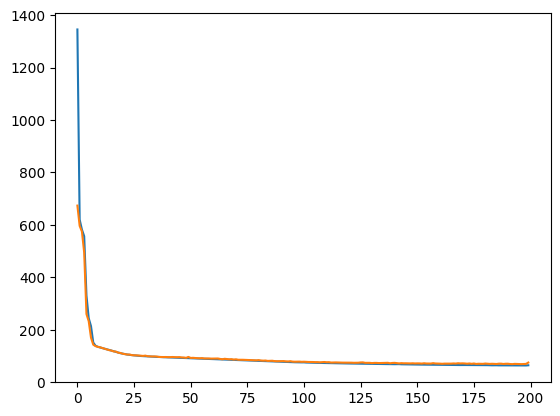

In [48]:
beta = 1
learning_rate = 1e-4
epochs = 200

train(beta=beta, learning_rate=learning_rate, epochs=epochs, save=True)

# Load model (if needed)

In [49]:
# Load the model if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BetaVAE(beta=beta).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
checkpoint = torch.load('betaVAE_{}_epochs.pt'.format(epochs))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

# Compare the reconstructions with the original data

In [50]:
def plot_reconstructions(model, data_loader, device, n=10):
    """Plot the original images as well as their reconstructions
        model : the BetaVAE that was trained
        data_loader : the DataLoader containing batches of images
        device : the device (cpu or gpu)
        n : number of images to plot
    """
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            data = data.cpu()
            recon_batch = recon_batch.cpu()
            for i in range(n):
                plt.subplot(2, n, i + 1)
                plt.imshow(data[i].permute(1,2,0), cmap='gray')
                plt.axis('off')
                plt.subplot(2, n, i + 1 + n)
                plt.imshow(recon_batch[i].permute(1,2,0), cmap='gray')
                plt.axis('off')
            plt.show()

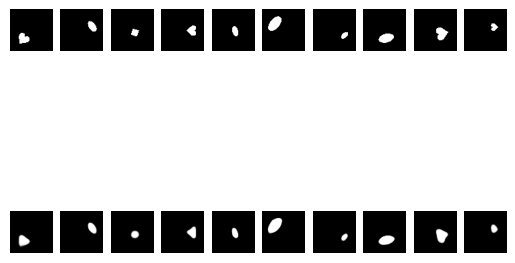

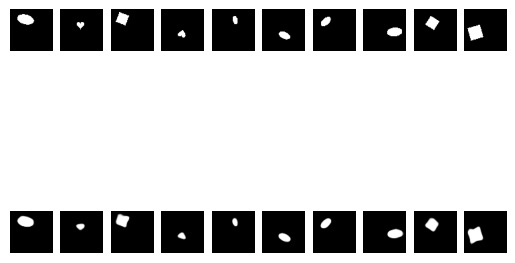

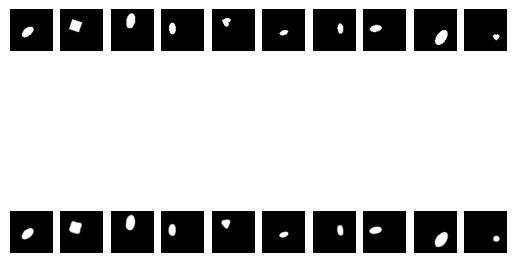

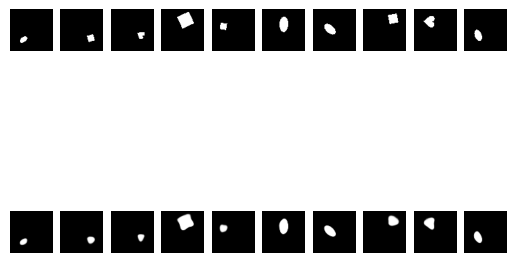

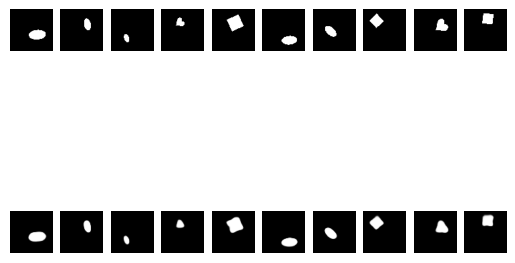

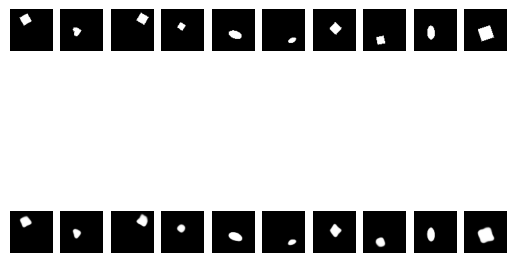

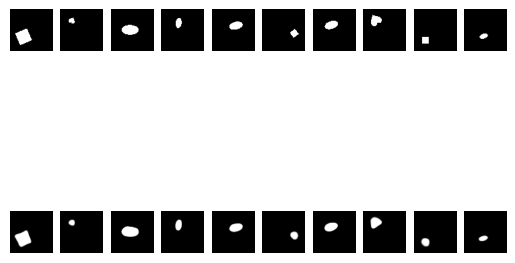

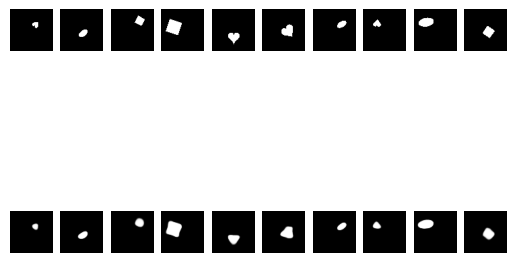

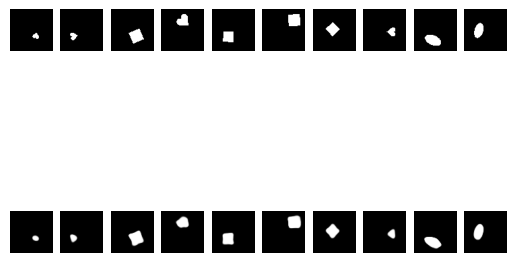

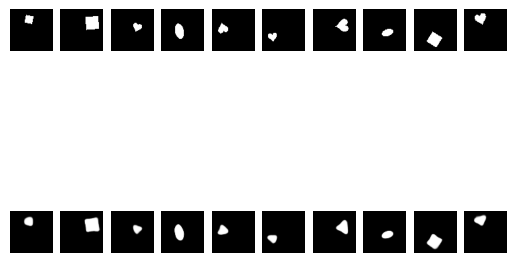

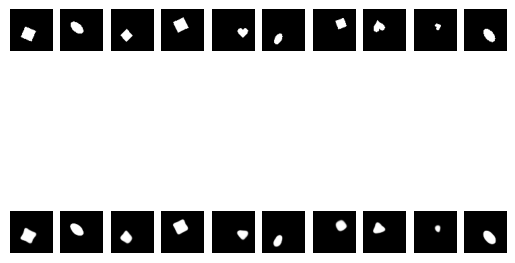

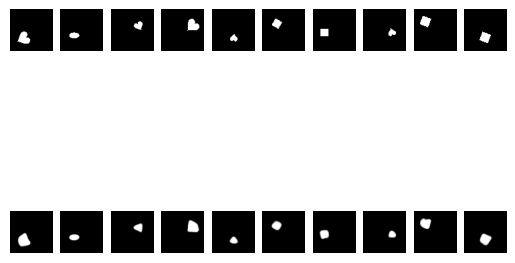

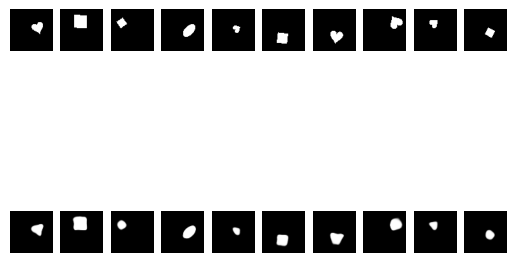

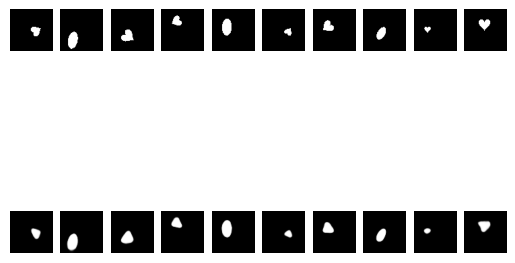

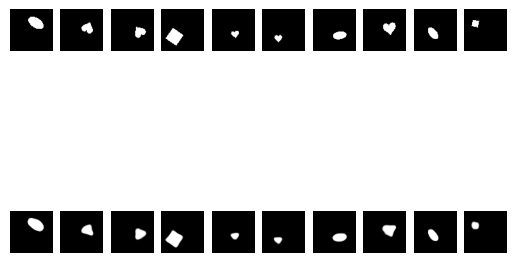

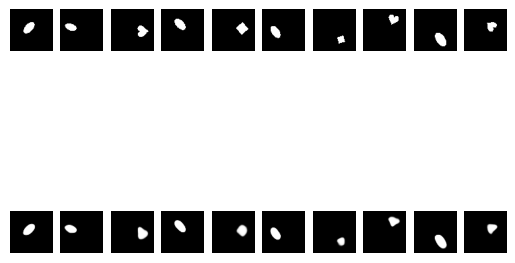

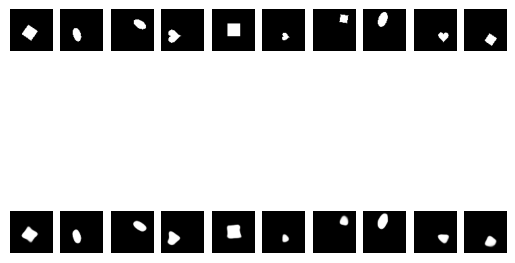

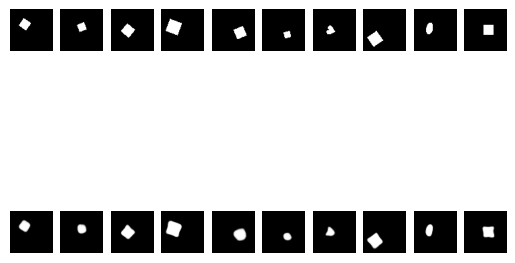

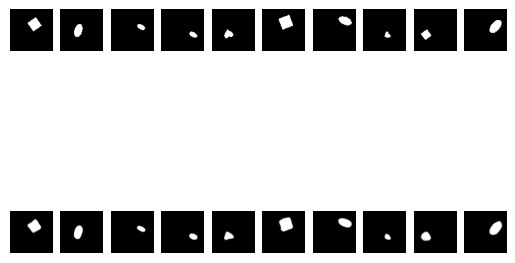

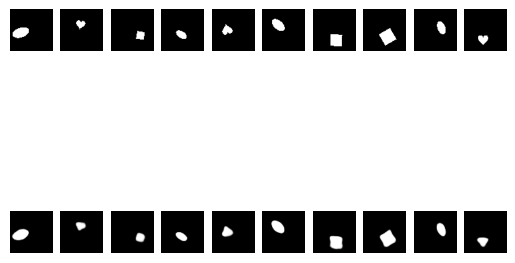

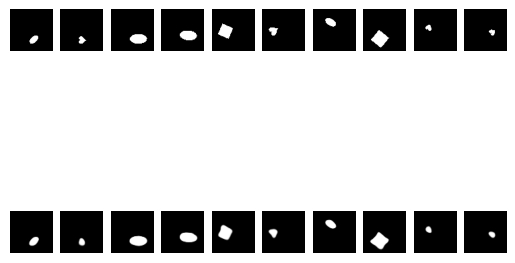

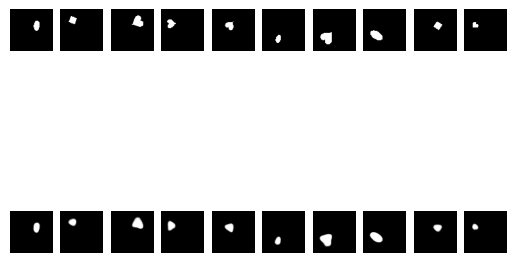

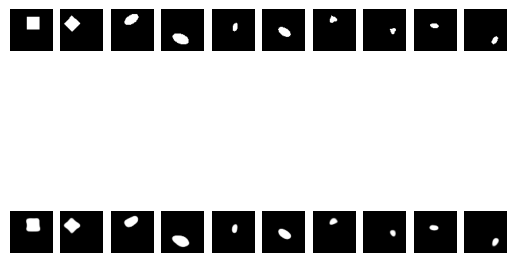

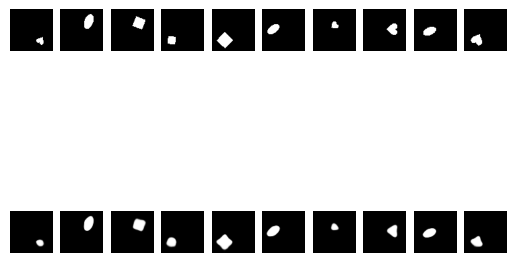

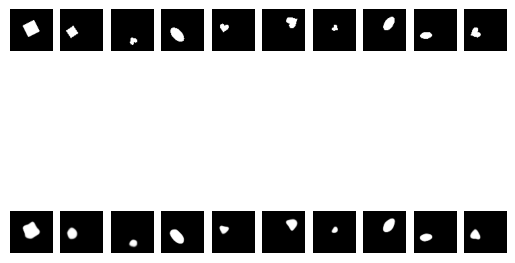

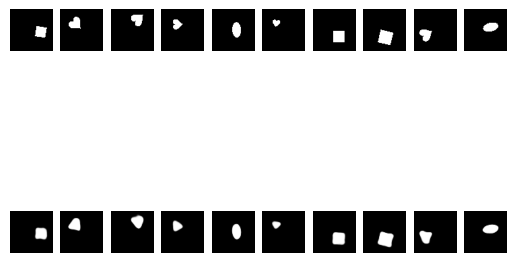

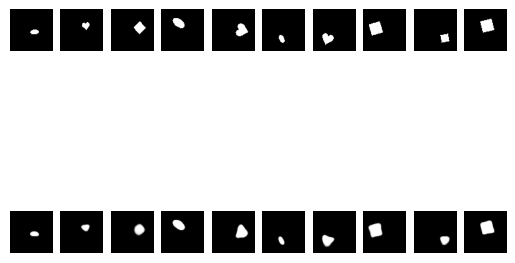

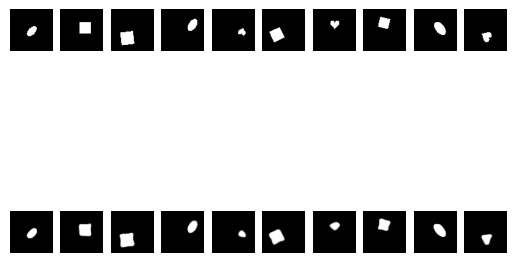

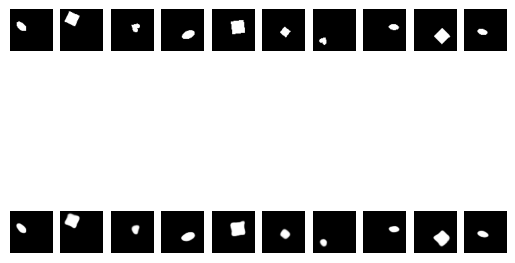

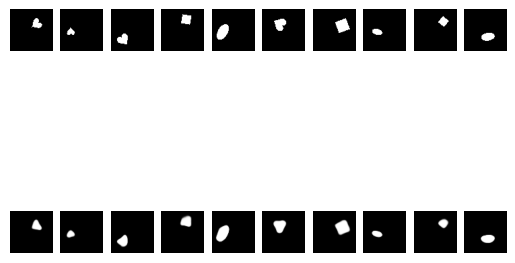

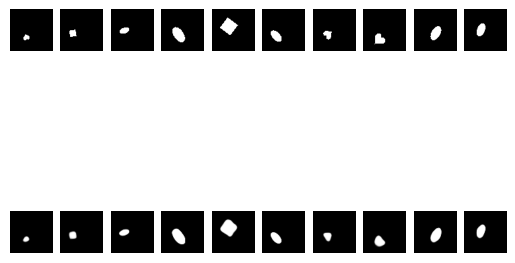

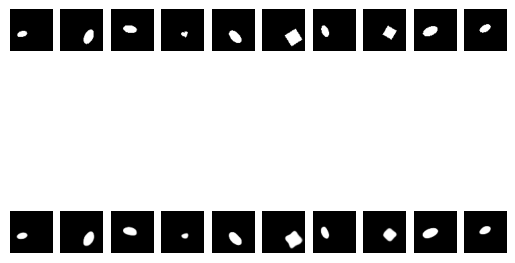

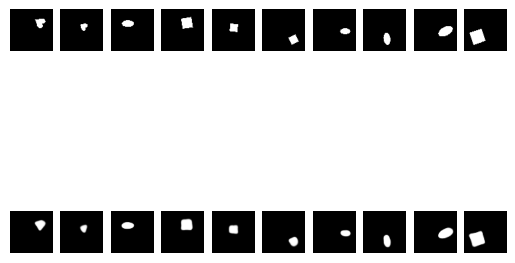

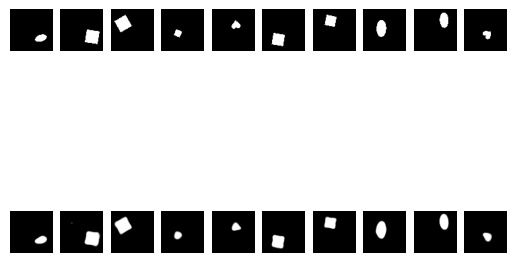

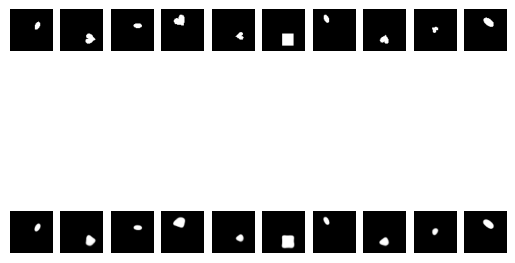

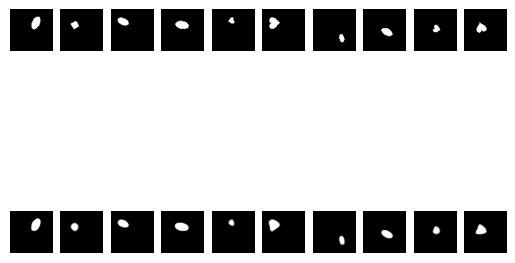

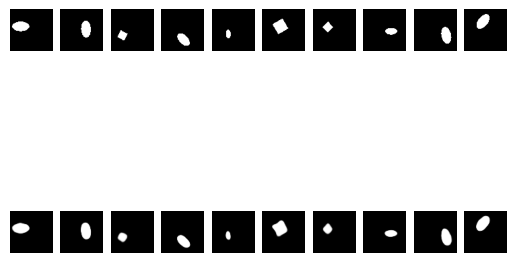

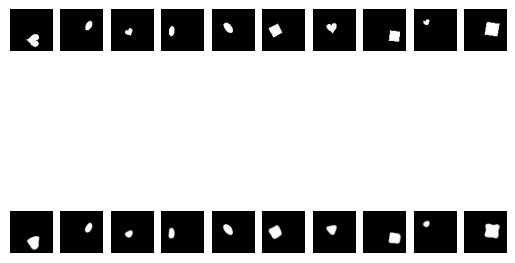

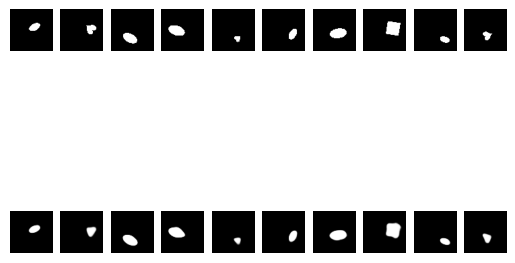

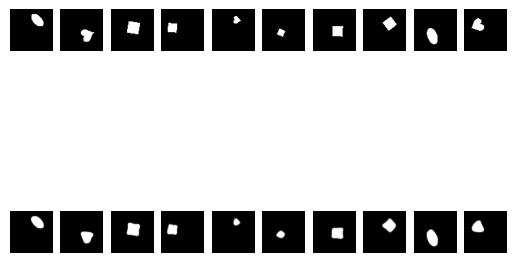

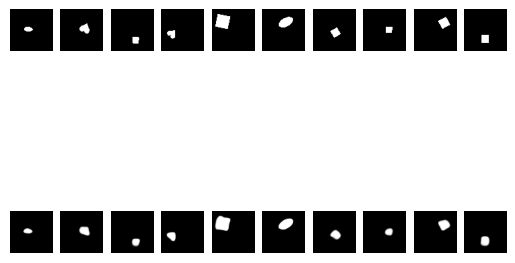

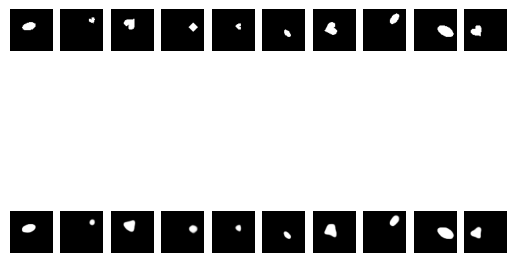

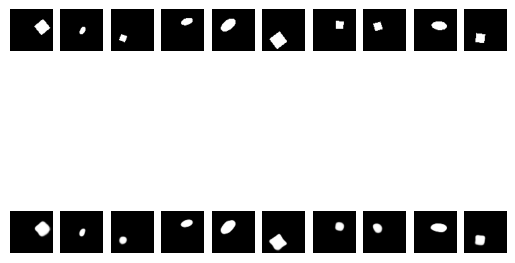

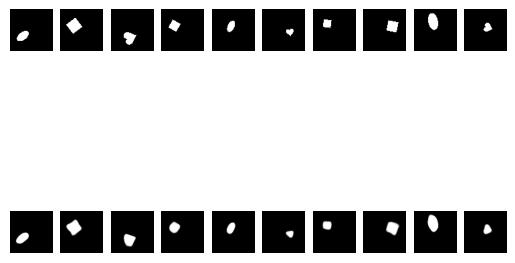

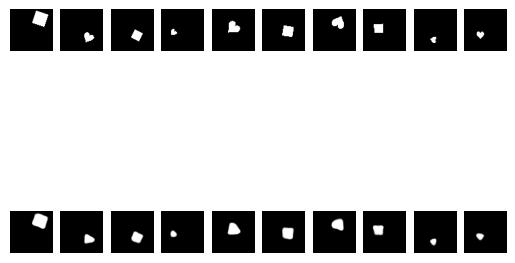

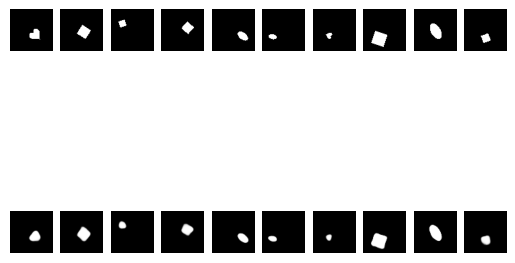

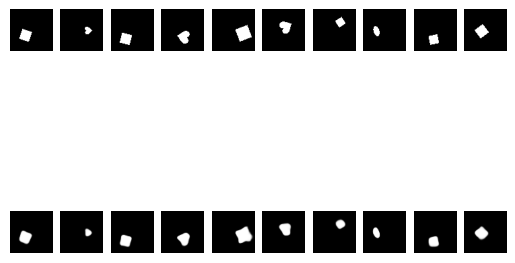

In [51]:
plot_reconstructions(model, imgs_testloader, device)

In [52]:
def plot_latent_traversals_each_dim(model, device, n=10, z_dim=10, traversal_range=3):
    """Plots the latent traversals along each dimension of the latent space
        model : the BetaVAE that was trained
        device : cpu or gpu
        n : number of images to plot
        z_dim : dimension of the latent space
        traversal_range : the range of values for the traversal (for ex. [-3, 3])
    """
    model.eval()
    with torch.no_grad():
        # Generate fixed latent codes
        fixed_z = torch.randn(n, z_dim).to(device)
        
        # Create traversal values
        traversal_values = torch.linspace(-traversal_range, traversal_range, n).to(device)
        
        # Loop over each dimension and create traversed latent codes
        for fixed_dim in range(z_dim):
            latent_codes = fixed_z.clone()
            for i in range(n):
                latent_codes[i, fixed_dim] = traversal_values[i]
            
            # Generate images from traversed latent codes
            reconstructions = model.decoder(latent_codes)
            
            # Plotting
            plt.figure(figsize=(n, 2))
            for i in range(n):
                plt.subplot(2, n, i + 1)
                plt.imshow(reconstructions[i].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Latent Dimension {fixed_dim+1}')
            plt.show()


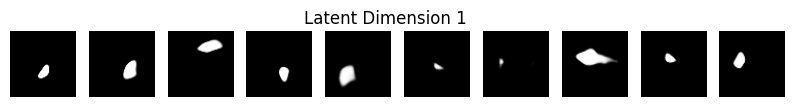

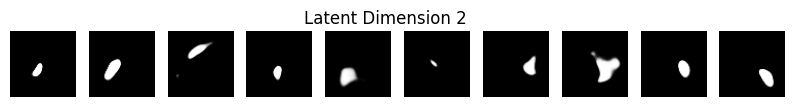

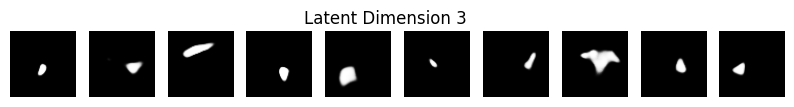

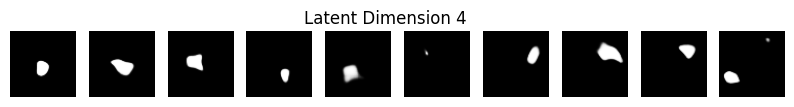

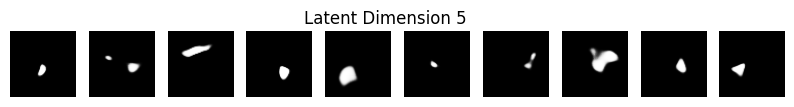

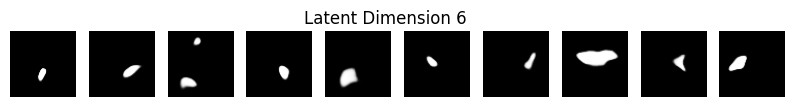

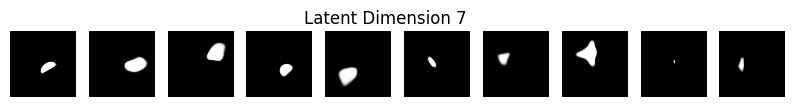

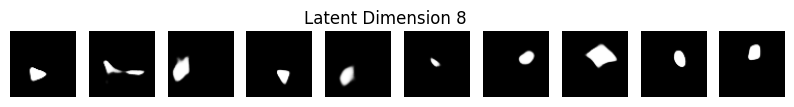

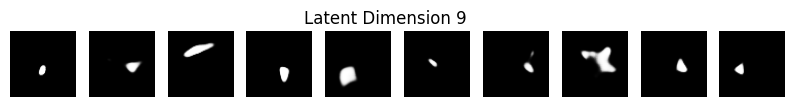

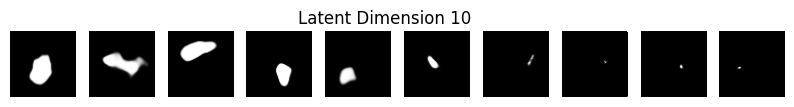

In [53]:
n = 10  
traversal_range = 3 

plot_latent_traversals_each_dim(model, device, n=n, z_dim=10, traversal_range=traversal_range)

# Disentanglement metric score for the BetaVAE

In [54]:
B = 150
L = 40
K = 6
z_batch = []
classes = []

for b in range(B):
    z_l = []
    y = np.random.randint(0, K)
    for l in range(L):
        # Sample a pair v1,l , v2,l such that they agree on their yth value
        v_1l = np.array([np.random.choice(np.unique(latent_classes[:,i])) for i in range(K)])
        v_2l = np.array([np.random.choice(np.unique(latent_classes[:,i])) for i in range(K)])
        v_1l[y] = v_2l[y]

        # simulate the images corresponding to the pair v1,l , v2,l
        idx_1 = np.where((latent_classes == v_1l).all(axis=1))[0]
        idx_2 = np.where((latent_classes == v_2l).all(axis=1))[0]
        
        # get the images
        imgs_1 = imgs[idx_1]
        imgs_2 = imgs[idx_2]
        
        # infer the expectation values of the latent representation z
        model.eval()
        z_1, _ = model.encoder(torch.tensor(imgs_1, dtype=torch.float).view(1, 1, 64, 64).to(device))
        z_2, _ = model.encoder(torch.tensor(imgs_2, dtype=torch.float).view(1, 1, 64, 64).to(device))
        z_1 = z_1.cpu().detach()
        z_2 = z_2.cpu().detach()
        z_diff = torch.abs(z_1 - z_2)
        z_l.append(z_diff)
    # compute the element-wise mean of the latent representation
    z_l_tensor = torch.tensor(np.array(z_l), dtype=torch.float)
    z_b_mean = torch.mean(z_l_tensor, dim=0)
    z_batch.append(z_b_mean)
    classes.append(y)

In [55]:
z_batch_tensor = torch.tensor(np.array(z_batch), dtype=torch.float).squeeze(1)
labels_tensor = torch.tensor(np.array(classes))

classifier_dataset = TensorDataset(z_batch_tensor, labels_tensor)
train_size = int(0.8 * len(classifier_dataset))
test_size = len(classifier_dataset) - train_size

classifier_train_dataset, classifier_test_dataset = random_split(classifier_dataset, [train_size, test_size])

classifier_traindataloader = DataLoader(classifier_train_dataset, batch_size=4, shuffle=False)
classifier_testdataloader = DataLoader(classifier_test_dataset, batch_size=4, shuffle=False)

In [56]:
classifier = nn.Sequential(
    nn.Linear(10, 6),
    nn.LogSoftmax(dim=1)
)

optimizer = optim.Adagrad(classifier.parameters(), lr=1e-2)
criterion = nn.NLLLoss()

epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    classifier.train()
    for inputs, labels in classifier_traindataloader:
        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

classifier.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in classifier_testdataloader:
        inputs = inputs
        outputs = classifier(inputs)
        _, predicted_indices = torch.max(outputs, 1)
        correct += (predicted_indices == labels).sum().item()
        total += inputs.size(0)
    
    score = 100 * correct / total
    print('Disentanglement metric score: %d %%' % (score))

Epoch [10/1000], Loss: 1.7959
Epoch [20/1000], Loss: 1.7897
Epoch [30/1000], Loss: 1.7840
Epoch [40/1000], Loss: 1.7789
Epoch [50/1000], Loss: 1.7744
Epoch [60/1000], Loss: 1.7702
Epoch [70/1000], Loss: 1.7664
Epoch [80/1000], Loss: 1.7629
Epoch [90/1000], Loss: 1.7595
Epoch [100/1000], Loss: 1.7563
Epoch [110/1000], Loss: 1.7533
Epoch [120/1000], Loss: 1.7504
Epoch [130/1000], Loss: 1.7476
Epoch [140/1000], Loss: 1.7450
Epoch [150/1000], Loss: 1.7424
Epoch [160/1000], Loss: 1.7399
Epoch [170/1000], Loss: 1.7375
Epoch [180/1000], Loss: 1.7351
Epoch [190/1000], Loss: 1.7329
Epoch [200/1000], Loss: 1.7306
Epoch [210/1000], Loss: 1.7285
Epoch [220/1000], Loss: 1.7264
Epoch [230/1000], Loss: 1.7243
Epoch [240/1000], Loss: 1.7223
Epoch [250/1000], Loss: 1.7203
Epoch [260/1000], Loss: 1.7184
Epoch [270/1000], Loss: 1.7165
Epoch [280/1000], Loss: 1.7147
Epoch [290/1000], Loss: 1.7128
Epoch [300/1000], Loss: 1.7111
Epoch [310/1000], Loss: 1.7093
Epoch [320/1000], Loss: 1.7076
Epoch [330/1000],